<a href="https://colab.research.google.com/github/vibferreira/DL_UBS/blob/main/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Deep Learning Assigment - UBS 2022

### Vitória Barbosa Ferreira - e2008984

# Has Oilpalm?

For this assignment, we ask you to train a deep learning model able to detect oil palm plantation in Planet images.
This is a binary classification task where label `0` means there is no oil palm plantation in the image, and `1` indicates the presence of an oil palm plantation.

Each image has a 3 meter spatial resolution, has 3 channels (RGB) and a size of 256 $\times$ 256 pixels.


You have access only to the train set, and we hold out an independent test set to evaluate your final classification performance (average F-Score).


The dataset has been collected from [Kaggle](https://www.kaggle.com/c/widsdatathon2019/data), and was proposed in the Women in Data Science Datathon 2019.

In [1]:
#-- connecting to Drive
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
!unzip '/content/drive/MyDrive/CDE_final_deep_learning/assignment-instructions.zip'
project_path = '/content/assignment'

Archive:  /content/drive/MyDrive/CDE_final_deep_learning/assignment-instructions.zip
  inflating: assignment/assignment.ipynb  
  inflating: assignment/traindata.csv  
  inflating: assignment/train.zip    


In [3]:
#-- unzip train.zip
%%capture
!unzip {project_path}/train.zip -d {project_path}

## Reading the data

The information on the training data is stored in the csv file `traindata.csv`.

In [4]:
import pandas as pd
train_df = pd.read_csv(os.path.join(project_path, "traindata.csv"))
train_df

,img_id,has_oilpalm
0,train/img_0000.jpg,0
1,train/img_0001.jpg,0
2,train/img_0002.jpg,0
3,train/img_0003.jpg,0
4,train/img_0004.jpg,0
...,...,...
7672,train/img_7672.jpg,0
7673,train/img_7673.jpg,0
7674,train/img_7674.jpg,0
7675,train/img_7675.jpg,0


The ``img_id`` column indicates the relative path to the image and the ``has_oilpalm`` columns give the corresponding class index.

Let us now dowload the data and train a simple Random Forest algorithm on the flatten representation of the training images.
As the data are **big** (~12GB if we donwload them in a float64 numpy array), we will use here only a subset of the data.

In [5]:
!pip install rasterio

     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [6]:
import numpy as np
import rasterio

N = 500
#-- Getting the training dataset (X,y)
X = np.zeros((N,256*256*3), dtype=np.uint8)
y = np.zeros((N,), dtype=np.uint8)
train_rf_model = train_df.sample(n=N)
for n in range(N):
  X[n,:] = rasterio.open(os.path.join(project_path,train_rf_model.iloc[n]['img_id'])).read().flatten()
  y[n] = train_rf_model.iloc[n]['has_oilpalm']

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
#-- Training a RF model
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, max_features=100, max_depth=25, oob_score=True, n_jobs=-1)
rf.fit(X,y)
print('OOB error: ', rf.oob_score_)

OOB error:  0.842


# Assignment instructions


This is now your turn to train the most accurate deep learning model you can.  

**Deadline**: January 16 2022 - 6 pm

You should upload your notebook on Moodle with your different experiments as well as a saved model that we can load and use to evaluate your performance on the test set.

Your notebook plays the role of a report. It should 
* describe the different experiments you have made
* include a summary of the results you have obtained 
* analyse these results
* include the code for only the main experiments.

We will pay attention to
* the design of the architecture,
* the explanation about the different experiments and how you get to the final results (summarize the information and the main issues you encountered and how you solved them, highlight the salient experiments) ,
* the cleanliness of the code.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.transforms import transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split, TensorDataset, WeightedRandomSampler # import DataLoader and TensorDataset
from prettytable import PrettyTable
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import ReduceLROnPlateau


from tqdm import tqdm

## Data Analysis

/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.



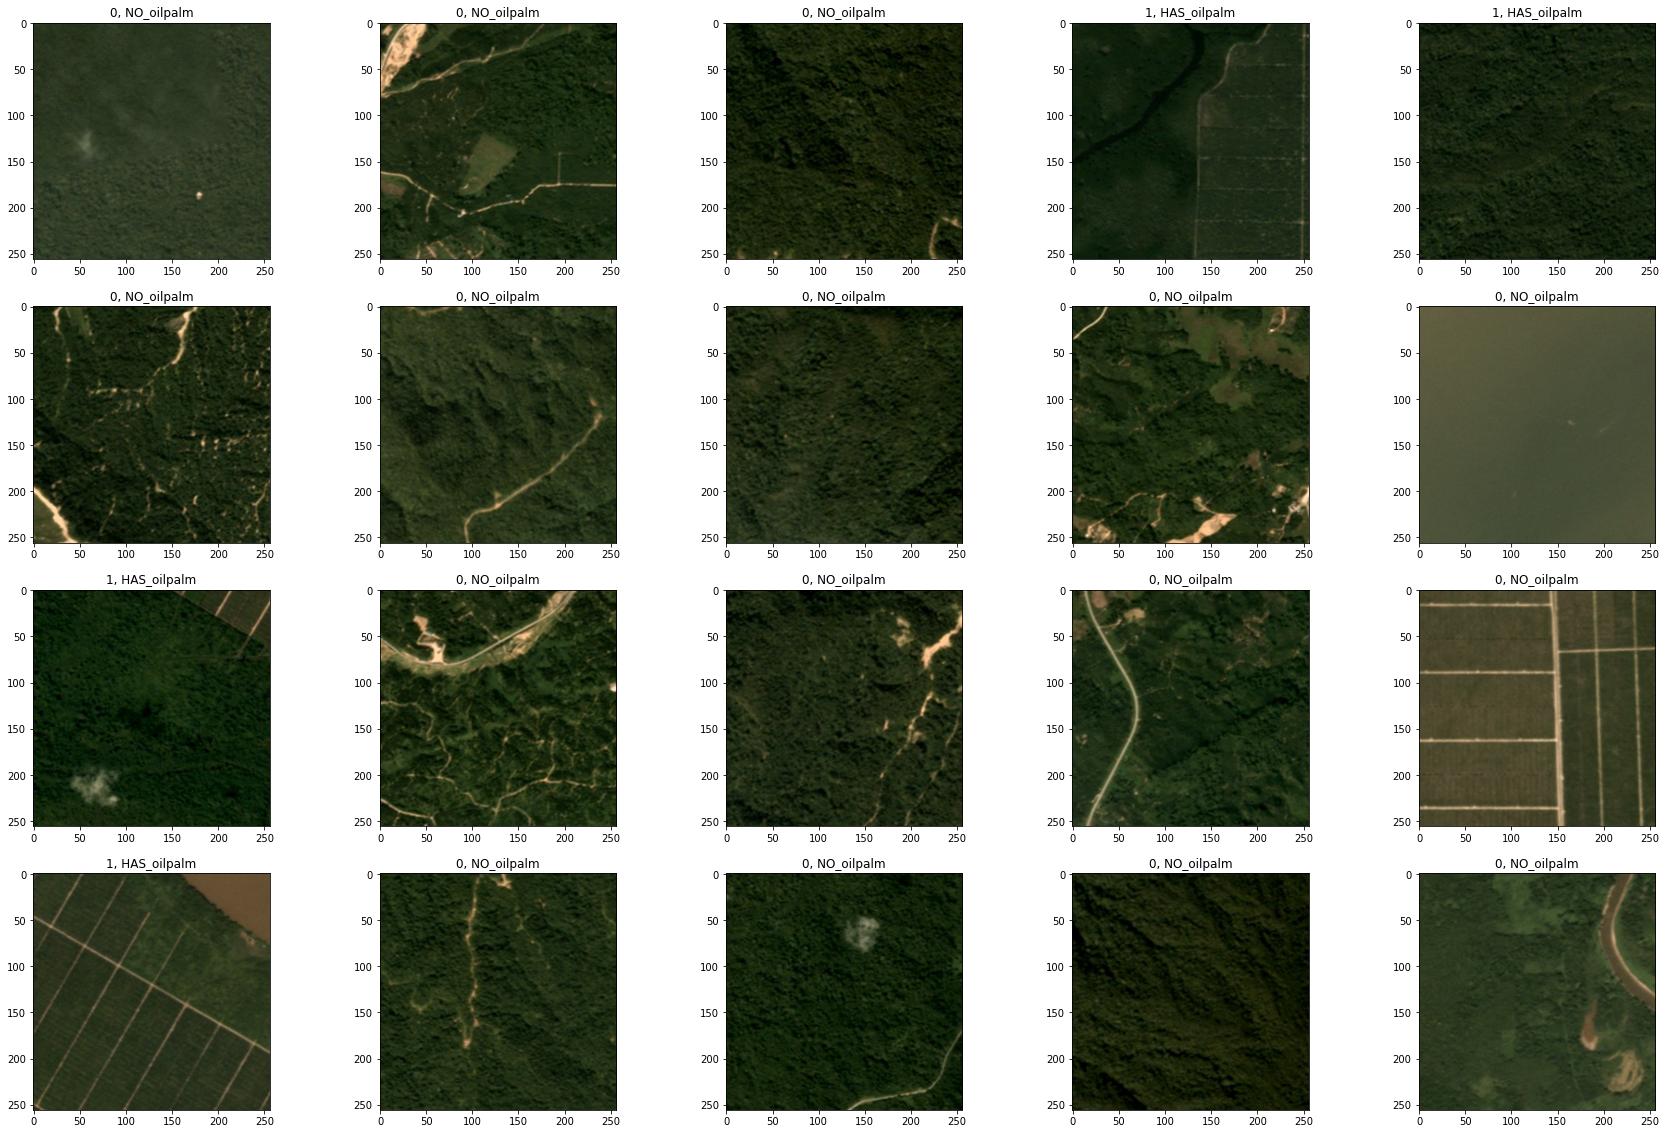

In [9]:
#@title Dataset
N = 20 # number of images 

X = np.zeros((N, 3, 256, 256), dtype=np.uint16)
y = np.zeros((N,), dtype=np.uint8)
train_rf_model = train_df.sample(n=N)

# Read the images 
for n in range(N):
  X[n,:] = rasterio.open(os.path.join(project_path,train_rf_model.iloc[n]['img_id'])).read()
  y[n] = train_rf_model.iloc[n]['has_oilpalm']
  # # Plot
  # plt.imshow(X[n,:].T)
  # plt.title(y[n])
  # plt.show()

# Plot
n_row = 4
n_col = 5
_, axs = plt.subplots(n_row, n_col, figsize=(30, 20))
axs = axs.flatten()
i = 0

for img, ax in zip(X, axs):
    ax.imshow(img.T)
    label = np.where(y[i] == 1, 'HAS_oilpalm', 'NO_oilpalm')
    ax.set_title(f'{y[i]}, {label}')
    i+=1
plt.show()

#### Noisy Data

In [10]:
noisy_df_samples = pd.DataFrame([train_df.iloc[4570], 
                train_df.iloc[1234],
                train_df.iloc[794],
                train_df.iloc[7461],
                train_df.iloc[6426],
                train_df.iloc[6397]])
noisy_df_samples

,img_id,has_oilpalm
4570,train/img_4570.jpg,1
1234,train/img_1234.jpg,1
794,train/img_0794.jpg,1
7461,train/img_7461.jpg,1
6426,train/img_6426.jpg,1
6397,train/img_6397.jpg,1


/usr/local/lib/python3.7/dist-packages/rasterio/__init__.py:220: NotGeoreferencedWarning:

Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.



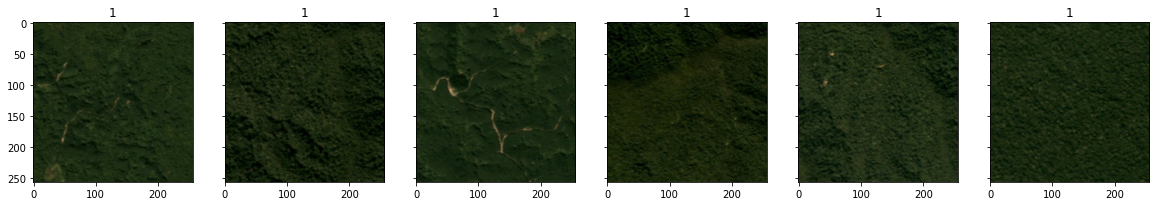

In [11]:
# Noisy Data
size = len(noisy_df_samples)
fig, ax = plt.subplots(ncols=size, figsize=(20,10), sharey='row')
for n in range(size):
  X[n,:] = rasterio.open(os.path.join(project_path,noisy_df_samples.iloc[n]['img_id'])).read()
  y[n] = noisy_df_samples.iloc[n]['has_oilpalm']

  # Plot
  ax[n].imshow(X[n,:].T)
  ax[n].set_title(y[n])

plt.show()

#### Imbalaced data

In [12]:
# Statistics 
class_count = train_df.groupby('has_oilpalm').count()
diff_classes = int(class_count.iloc[0] - class_count.iloc[1])
total = len(train_df)

print('Total N samples:', total)
print('Diff among classes: ', diff_classes)
class_count

Total N samples: 7677
Diff among classes:  5767


,img_id
has_oilpalm,
0,6722
1,955


In [13]:
# Summary Statistics
class_count.describe()

,img_id
count,2.000000
mean,3838.500000
std,4077.884807
min,955.000000
25%,2396.750000
50%,3838.500000
75%,5280.250000
max,6722.000000


In [14]:
# Viz 
pie = class_count.reset_index()
class_count['label'] = np.where(pie['has_oilpalm'] == 1, 'HAS_oilpalm', 'NO_oilpalm')
fig = px.pie(class_count, values='img_id', names='label', title=f'Data distribution')
fig.show()

In [15]:
#@title Quadruplicating Dataset - Tested, not used in the final implementation
# has_oilpalm = train_df[(train_df['has_oilpalm'] == 1)]
# no_oilpalm = train_df[(train_df['has_oilpalm'] == 0)]

# has_oilpalm_hp_x4=pd.concat([has_oilpalm, has_oilpalm, has_oilpalm, has_oilpalm, has_oilpalm, has_oilpalm])

# #Reindexing
# train_df.index = pd.RangeIndex(len(train_df.index))
# train_df.index = range(len(train_df.index))

# train_df = pd.concat([has_oilpalm_hp_x4, no_oilpalm])
# print(len(train_df))

# class_count = train_df.groupby('has_oilpalm').count()
# pie = class_count.reset_index()
# class_count['label'] = np.where(pie['has_oilpalm'] == 1, 'HAS_oilpalm', 'NO_oilpalm')
# fig = px.pie(class_count, values='img_id', names='label', title=f'Data distribution')
# fig.show()

# train_df.index = pd.RangeIndex(len(train_df.index))
# train_df.index = range(len(train_df.index))

# df = train_df[~train_df.index.duplicated()] 
# len(train_df)

## Initial Steps

**DataLoader:** The DataLoader class of PyTorch enables easy access to the samples by iterating around the dataset. In order to feed the DataLoader with the images and their corresponding labels, a custom Dataset ([CustomDataset class](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files)) was created. 

**Normalisation:** The dataset is normalised between 0 and 1 to reduce the skewness of the data, which helps learn the patterns better and faster. 

**Imabalaced Dataset:** As shown in the previous section, the dataset is fairly imbalaced, which may negatively impact the predictions, as the model may not have enough data on the imbalaced class to return accurate results. In addition, imbalaced datasets may be a problem when splitting the data as the less representative classes may not be in enough quantity to train or test the model. In order to minimize the impact of the imbalaced dataset, the samples were weighted according to their class distribution using the built-in pytorch function WeightedRandomSampler. 

Another technique experienced during the process was oversampling by quadruplicating the minor class with repeated samples of itself. Although it significantly increased the available data, it seemed to contribute even more to overfitting.

**Noisy Data**: The data is also significantly noisy,especially with images labeled as containing oil palm when in fact they only contain rainforest.This sort of noise will impact the accuracy of the predictions,as the model will struggle to converge to a unique solution.

#### Handy Functions

In [16]:
# Handy Functions

# Weighted Sampler - Imbalanced Dataset
def weighted_random_sampler(target):
  """ Return sample weights based on the class distribution"""
  target = target['has_oilpalm']
  label_counts = np.bincount(target)
  labels_weights = 1. / label_counts
  samples_weight = torch.tensor([labels_weights[t] for t in target]).double()
  sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

  return sampler, samples_weight

# DataLoader
def dataloader(data,
               project_path, 
               sampler,
               transform, 
               batch_size):

  dataset = CustomDataset(project_path, data, transform=transform)
  dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

  return dataloader, dataset

# Loss/Cost function
def loss_func(y_hat, y):
    return nn.CrossEntropyLoss()(y_hat, y) # in relation to the class probability 


def train_epoch(model_, 
                optimizer_, 
                loss_func, 
                dataloader, 
                device):
  model_.train()
  train_correct = 0
  train_loss = []

  loop = tqdm(dataloader, leave = False)
  for x_train_batch, y_train_batch in loop:
    # Inputs
    x_train_batch = x_train_batch.to(device)
    y_train_batch = y_train_batch.to(device)

    y_hat = model_(x_train_batch) # forward pass

    loss = loss_func(y_hat, y_train_batch) # compute the loss
    loss.backward() # obtain the gradients with respect to the loss
    optimizer_.step() # perform one step of gradient descent
    optimizer_.zero_grad() # reset the gradients to 0
    y_hat_class = torch.argmax(y_hat.detach(), axis=1) # we assign an appropriate label based on the network's prediction
    train_correct += torch.sum(y_hat_class==y_train_batch)
    train_loss.append(loss.item()/len(x_train_batch))

    # Update progress bar
    loop.set_description(f'Epoch[{e}/{epochs}]')
  
  train_accuracy = train_correct/len(dataloader.dataset)
  mean_loss = sum(train_loss)/len(train_loss)

  return train_loss, train_accuracy, mean_loss

def val_epoch(model_, 
              loss_func, 
              dataloader, 
              device):
  model_.eval()
  tmp_val_loss = 0
  val_correct = 0

  loop = tqdm(dataloader, leave = False)
  with torch.no_grad():
    for x_val_batch, y_val_batch in loop:
      # Sending the batchs to the device
      x_val_batch = x_val_batch.to(device)
      y_val_batch = y_val_batch.to(device)
      # predictions
      y_val_hat = model_(x_val_batch) # forward pass
      tmp_val_loss += loss_func(y_val_hat, y_val_batch).item() # compute the loss
      y_val_hat_class = torch.argmax(y_val_hat.detach(), axis=1) # we assign an appropriate label based on the network's prediction
      val_correct += torch.sum(y_val_hat_class==y_val_batch)

    # Update progress bar
    loop.set_description(f'Epoch[{e}/{epochs}]')
  loss_val = tmp_val_loss/len(dataloader.dataset) # compute the average loss   
  accuracy_val = val_correct/len(dataloader.dataset)

  return loss_val, accuracy_val, y_val_hat_class 

def saveModel(model_, model_name):
      torch.save(model_.state_dict(), f"{model_name}.pth")

def plot_comparison(dataloader, 
                    traini_loss, 
                    vali_loss, 
                    train_acc, 
                    val_acc,
                    epochs=40):
  
  plt.figure(figsize=(13, 5))
  plt.subplot(1, 2, 1)
  plt.title('Training and Validation Loss')
  plt.plot(list(range(epochs*len(dataloader))),traini_loss, label="train")
  plt.plot(list(range(0, epochs*len(dataloader), len(dataloader))), vali_loss, label="val")
  plt.xlabel('Iterations')
  plt.ylabel('Cross Entropy Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Accuracy')
  plt.plot(list(range(epochs)), train_acc, label="train")
  plt.plot(list(range(epochs)), val_acc, label="val")
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")

# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)
# count_parameters(resnet18)
# model = LeNet7(3, 2)
# count_parameters(resnet18)

def test_on_testset(model_,dataloader):
  y_hat_test = []
  y_true_test = []

  for x , y in tqdm(dataloader):

    # Sending the batchs to the device
    x = x.to(device)
    y = y.to(device)

    # Predictions
    y_hat = model_(x)
    
    # Assign appropriate class
    y_hat_class = torch.argmax(y_hat.detach(), axis=1)

    # Save predictions
    y_hat_test.append(y_hat_class)

    # Save true labels
    y_true_test.append(y)

  return torch.stack(y_hat_test).flatten(), torch.stack(y_true_test).flatten()

def conf_matrix(y_true, y_pred, model_name):
  # Confusion Matrix
  cm = confusion_matrix(y_true, y_pred)

  # Plot
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)
  ax.set_title(f'Confusion Matrix - {model_name}') 
  plt.show()


#### Split
The dataset is split into train, validation, and test sets.Despite an external test routine, which the author of this assigment will not have access to,it is always a good idea to test the results using an unseen test dataset. In this regard,  20% of the total data is set to test and another 20% to validate the results during training. The remaining 60% of the dataset is used to train the models. 

The weights for the 0 and 1 classes are 0.0007468259895444362 and 005076142131979695, respectively.

In [17]:
from torch.utils.data import Dataset
from torchvision.io import read_image

# Defining a custom dataset 
class CustomDataset(Dataset):
  """ retrieves the dataset’s features and labels one sample at a time """
  def __init__(self, path, df, transform=None):
    self.path = path
    self.transform = transform
    # self.data_samples = df
    self.df = df

  def __len__(self):
    """returns the number of samples in the dataset"""
    return len(self.df) 
               
  def __getitem__(self, idx):
    """ loads and returns a sample from the dataset at the given index idx """
    # images
    file_id = self.df['img_id'].iloc[idx]
    img_path = os.path.join(self.path, file_id)
    img = read_image(img_path)

    # labels
    label = self.df['has_oilpalm'].iloc[idx]

    # where the transformations are passed to (WHOLE DATA)
    if self.transform:
      img = self.transform(img)

    return img, label

In [18]:
# Batch size
batch_size=128

# Normalisation
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor() # set to the range [0, 1]
            # transforms.Normalize(mean=(.5, .5, .5), # mean of each channel
            #                      std=(1=.5, .5, .5)) # std of each channel
            ])

# Split dataset into Train and Test
train, val = train_test_split(train_df, test_size=0.2, random_state=0, shuffle=True)
train, test = train_test_split(train, test_size= len(val), random_state=0, shuffle=True)

# Sampler 
sampler_train, weight_train = weighted_random_sampler(train)
sampler_test, weights_test = weighted_random_sampler(val)

# DataLoader
train_dataloader, train_dataset = dataloader(train, project_path, sampler_train, transform, batch_size)
val_dataloader, val_dataset = dataloader(val, project_path, sampler_test, transform, batch_size)
test_dataloader, test_dataset = dataloader(test, project_path, sampler_test, transform, batch_size)

# Summary of the Datasets
print('Total dataset:', train_df.shape[0])
print('Total training:', len(train_dataset))
print('Total validation:', len(val_dataset))
print('Total testing:', len(test_dataset))

print('Weights:\n', {i:label for i, label in enumerate(np.unique(weights_test))})

Total dataset: 7677
Total training: 4605
Total validation: 1536
Total testing: 1536
Weights:
 {0: 0.0007468259895444362, 1: 0.005076142131979695}


In [19]:
# Number of images of each label into training and testing
count_train = train.groupby('has_oilpalm').count()
count_train['split']='train'

count_val = val.groupby('has_oilpalm').count()
count_val['split']='val'

count_test = test.groupby('has_oilpalm').count()
count_test['split']='test'

pd.concat([count_train, count_val,count_test])

,img_id,split
has_oilpalm,,
0,4045,train
1,560,train
0,1339,val
1,197,val
0,1338,test
1,198,test


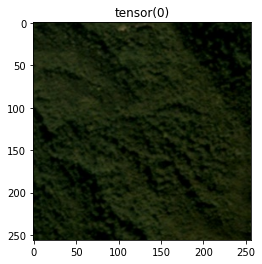

In [20]:
# Check DataLoader's content of first image in the Test Set
display = next(iter(test_dataloader))
img = display[0][0].T
title = display[1][0]
plt.imshow(img)
plt.title(title)
plt.show()

## Baseline Deep Learning Model - LeNET

***Note 1: The estimated time to run this notebook from this cell on is 45 minutes (on GPU).***


LeNET was used as a baseline deep learning model LeNET is one of the first convolutional neural networks widely used in image classificationThe choice of LeNET is justified by its simple architecture, straightforward implementation and previous experience during classes.

Apart from the convolution layers batch normalisation was added to each layer aiming for a more stable learning process. In addition,dropout layers were added to the last fully connected layers to improve generalisation. Because the model is still significantly overfit, a L2 regularization (weight_decay) was added to the optimizer to punish overcomplicated models.

Batch size was set at 128 as it shows more stable results during training.
The chosen optmizer was Stochastic Gradient Descent, with an initial learning rate of 0.001 and momentum of 0.9.
A scheduler is also included to reduce the learning rate based on training accuracy.It works by reducing the learning rate after no improvement is observed in the validation loss. 

Note: *The training and validation functions/loop are authored by Charlotte Pelletier for the Deep Learning at UBS, 2021-2022.*


In [21]:
#@title LeNET5 - just for tests
# class LeNet5(nn.Module):
#     def __init__(self, n_channels, n_classes):
#         super(LeNet5, self).__init__()
#         #-- convolutional layers
#         self.conv1 = nn.Conv2d(n_channels, 32, 5)
#         self.conv1_bn = nn.BatchNorm2d(32)

#         self.conv2 = nn.Conv2d(32, 64, 5)
#         self.conv2_bn = nn.BatchNorm2d(64)

#         self.conv3 = nn.Conv2d(64, 128, 5)
#         self.conv3_bn = nn.BatchNorm2d(128)

#         #-- fully connected layers
#         self.fc1 = nn.Linear(128*28*28, 128)
#         self.fc1_bn = nn.BatchNorm1d(128)

#         self.fc2 = nn.Linear(128, n_classes)
#         self.fc2_bn = nn.BatchNorm1d(128)

#         # % of neurons to dropout
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         # Conv --> Batch --> ReLU --> MaxPool
#         x = self.conv1(x)  
#         x = F.relu(self.conv1_bn(x))
#         x = F.max_pool2d(x, 2)

#         x = self.conv2(x)  
#         x = F.relu(self.conv2_bn(x))
    
#         x = F.max_pool2d(x, 2)

#         x = self.conv3(x)  
#         x = F.relu(self.conv3_bn(x))
#         x = F.max_pool2d(x, 2)

#         # flatten all dimensions except the batch dimension
#         x = torch.flatten(x, start_dim=1)
#         x = self.fc1(x)
#         # DropOut
#         x = self.dropout(x)

#         x = F.relu(self.fc1_bn(x))
#         # DropOut
#         x = self.dropout(x)

#         logits = self.fc2(x)
#         return logits

In [22]:
# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [23]:
class LeNet7(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(LeNet7, self).__init__()
        #-- convolutional layers
        self.conv1 = nn.Conv2d(n_channels, 32, 5)
        self.conv1_bn = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv2_bn = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 64, 5)
        self.conv3_bn = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, 5)
        self.conv4_bn = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 128, 5)
        self.conv5_bn = nn.BatchNorm2d(128) 

        #-- fully connected layers
        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc1_bn = nn.BatchNorm1d(128)

        self.fc2 = nn.Linear(128, n_classes)
        self.fc2_bn = nn.BatchNorm1d(128)

        # % of neurons to dropout
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Conv --> BatchNorm --> ReLU --> MaxPool
        x = self.conv1(x)  
        x = F.relu(self.conv1_bn(x))
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)  
        x = F.relu(self.conv2_bn(x))
    
        x = F.max_pool2d(x, 2)

        x = self.conv3(x)  
        x = F.relu(self.conv3_bn(x))
        x = F.max_pool2d(x, 2)

        x = self.conv4(x)  
        x = F.relu(self.conv4_bn(x))
        x = F.max_pool2d(x, 2)

        x = self.conv5(x)  
        x = F.relu(self.conv5_bn(x))
        x = F.max_pool2d(x, 2)

        # flatten all dimensions except the batch dimension
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        # DropOut
        x = self.dropout(x)

        x = F.relu(self.fc1_bn(x))
        # DropOut
        x = self.dropout(x)

        logits = self.fc2(x)
        return logits

In [71]:
LeNet7(3, 2)

LeNet7(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv5_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=2, bias=Tru

In [188]:
train_loss = [] # track of the training loss
train_accuracy = [] # track of the training accuracy of the model
val_loss = [] # track of the validation loss
val_accuracy = [] # track of the validation accuracy of the model
epochs = 50 # number of epochs

model_le = LeNet7(3, 2)
model_le.to(device)
best_accuracy = 0.0

# optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.01) # with regularizer
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.SGD(model_le.parameters(), lr=0.01, momentum=0.95, weight_decay=0.01)

scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)

# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience = 5, verbose = True)

for e in range(epochs):
    
  epoch_train_loss, epoch_train_accuracy, mean_loss = train_epoch(model_le, optimizer, loss_func, train_dataloader, device)
  epoch_val_loss, epoch_val_accuracy, _ = val_epoch(model_le, loss_func, val_dataloader, device)
  scheduler.step(epoch_val_accuracy)

  train_loss.extend(epoch_train_loss)
  train_accuracy.append(epoch_train_accuracy)
  val_loss.append(epoch_val_loss)
  val_accuracy.append(epoch_val_accuracy)

  # Save the model with the best accuracy 
  if epoch_val_accuracy > best_accuracy:
    saveModel(model_le, 'best_lenet7')
    best_accuracy = epoch_val_accuracy
    ep=e

Epoch     3: reducing learning rate of group 0 to 1.0000e-03.


Epoch     5: reducing learning rate of group 0 to 1.0000e-04.


Epoch     7: reducing learning rate of group 0 to 1.0000e-05.


Epoch     8: reducing learning rate of group 0 to 1.0000e-06.


Epoch     9: reducing learning rate of group 0 to 1.0000e-07.


Epoch    10: reducing learning rate of group 0 to 1.0000e-08.


#### Results LeNET7
After several attempts to regularise the model, the graphs below show the best results. Without any regularization (dropout, weight_decay, etc) or learning rate optimization (scheduler), the training accuracy would go up to 95%, but the validation accuracy would remain between 70 and 80%, indicating that the model quite overfits. By regularizing and optimizing the learning rate, the model still overfits, but to a lesser degree. 


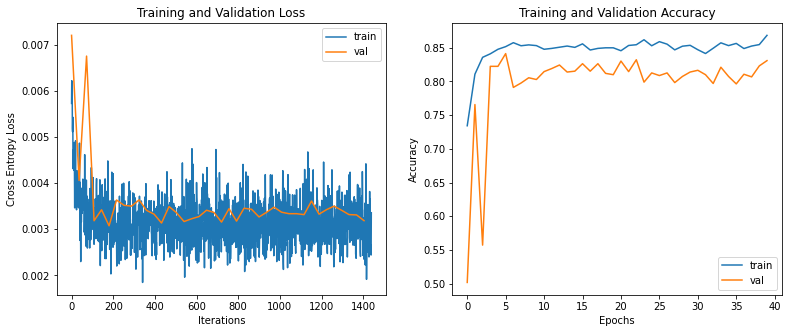

In [190]:
plot_comparison(train_dataloader, train_loss, val_loss, train_accuracy, val_accuracy)

## ResNet18

In the sequence a more complex and widely used model for image classification were selected, ResNet18. Pytorch has a pretrained version of ResNet18 in the package torchvision under models. 
The main reasons for choosing ResNet18 are:

*   Learning how to use and adapt a pretrained model;
*   Possible application on my thesis topic;
*   High accuracies on previous applications;
*   Less complex then other standard image classification models, such as VGG and AlexNet;


The pretrained model was used as feature-extractor, by freezing the weights of the first layers and only updating the last few layers.








In [24]:
from torchvision import models

dl_models = dir(models)

# Looking for ResNet functions
result = [i for i in dl_models if i.startswith('r')]
result

['regnet',
 'regnet_x_16gf',
 'regnet_x_1_6gf',
 'regnet_x_32gf',
 'regnet_x_3_2gf',
 'regnet_x_400mf',
 'regnet_x_800mf',
 'regnet_x_8gf',
 'regnet_y_16gf',
 'regnet_y_1_6gf',
 'regnet_y_32gf',
 'regnet_y_3_2gf',
 'regnet_y_400mf',
 'regnet_y_800mf',
 'regnet_y_8gf',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d']

In [25]:
# Load the ResNet Network
resnet18 = models.resnet18(pretrained=True) # to train using our data
# resnet18_trained = models.resnet18(pretrained=True) # use the pretrained model

model_params = resnet18.parameters()
# Freezing Layers
for item, param in enumerate(model_params):
    if item < 61:
      param.requires_grad = False

# Modifying the Last Layer
# fc = nn.Sequential(nn.Linear(in_features=512, out_features=2, bias=True), nn.LogSoftmax(dim=1)) # 512 neurons, 2 classes
fc = nn.Sequential(nn.Linear(in_features=512, out_features=2, bias=True), nn.ReLU()) # 512 neurons, 2 classes

#Attaching custom classifier to the model 
resnet18.fc = fc

resnet18

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
train_loss_res = [] # track of the training loss
train_accuracy_res = [] # track of the training accuracy of the model
val_loss_res = [] #  track of the validation loss
val_accuracy_res = [] # track of the validation accuracy of the model
epochs = 50 # number of epochs

model_res = resnet18
model_res.to(device)
best_accuracy = 0.0
# optimizer = optim.Adam(model_res.parameters(), lr=0.001)
optimizer = optim.SGD(model_res.parameters(), lr=0.001, momentum=0.95, weight_decay=0.01)
# scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=0, verbose=True)

for e in range(epochs):
  epoch_train_loss, epoch_train_accuracy, mean_loss= train_epoch(model_res, optimizer, loss_func, train_dataloader, device)
  epoch_val_loss, epoch_val_accuracy, _ = val_epoch(model_res, loss_func, val_dataloader, device)
  # scheduler.step(epoch_val_accuracy)

  train_loss_res.extend(epoch_train_loss)
  train_accuracy_res.append(epoch_train_accuracy)
  val_loss_res.append(epoch_val_loss)
  val_accuracy_res.append(epoch_val_accuracy)

  # Save the model with the best accuracy 
  if epoch_val_accuracy > best_accuracy:
    saveModel(model_res, 'best_resnet18')
    best_accuracy = epoch_val_accuracy
    ep = e

In [36]:
ep

34

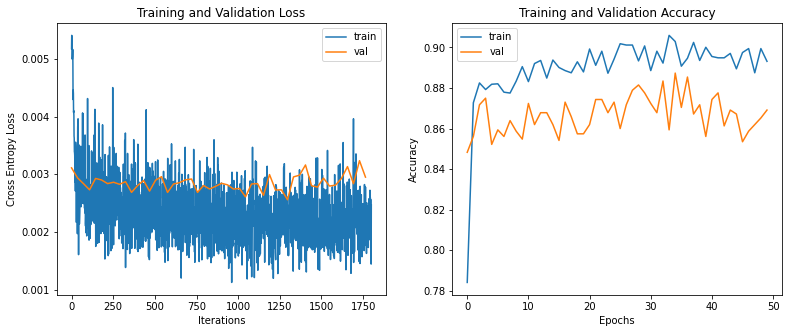

In [27]:
plot_comparison(train_dataloader, train_loss_res, val_loss_res, train_accuracy_res, val_accuracy_res, epochs=epochs)

## Models Evaluation 

Apart from testing in the validation set, the model was also evaluated in the test set. In addition to the overall acuracy (OA), an optmistimic measure, especially when considering a fairly unbalaced dataset, a confusion matrix and the f1 score were also computed. 

The outputs have shown an OA of XXXXX for LeNet7 and XXXXX for ResNet18



Regarding the number of parameters, LeNet7 has XXXXX times more parameters than ResNet18 because we only trained the last two layers of resnet. 



In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import seaborn as sns

In [29]:
# model_le = LeNet7(3, 2)
# model_le.to(device)
# model_res = resnet18
# model_res.to(device)

print(count_parameters(model_le)) # trained from scratch
print(count_parameters(model_res)) # trained just th

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|   conv1.weight  |    2400    |
|    conv1.bias   |     32     |
| conv1_bn.weight |     32     |
|  conv1_bn.bias  |     32     |
|   conv2.weight  |   51200    |
|    conv2.bias   |     64     |
| conv2_bn.weight |     64     |
|  conv2_bn.bias  |     64     |
|   conv3.weight  |   102400   |
|    conv3.bias   |     64     |
| conv3_bn.weight |     64     |
|  conv3_bn.bias  |     64     |
|   conv4.weight  |   204800   |
|    conv4.bias   |    128     |
| conv4_bn.weight |    128     |
|  conv4_bn.bias  |    128     |
|   conv5.weight  |   409600   |
|    conv5.bias   |    128     |
| conv5_bn.weight |    128     |
|  conv5_bn.bias  |    128     |
|    fc1.weight   |   262144   |
|     fc1.bias    |    128     |
|  fc1_bn.weight  |    128     |
|   fc1_bn.bias   |    128     |
|    fc2.weight   |    256     |
|     fc2.bias    |     2      |
|  fc2_bn.weight  |    128     |
|   fc2_bn

In [30]:
##-- Load the models

# Lenet
path = "/content/best_lenet7.pth"
model_le.load_state_dict(torch.load(path))

# ResNET18
path = "/content/best_resnet18.pth"
model_res.load_state_dict(torch.load(path))

# Test on Test set --> Whole Test Dataset, not single Batch
y_pred_le, y_true_le = test_on_testset(model_le,test_dataloader)
y_pred_res, y_true_res = test_on_testset(model_res,test_dataloader)

100%|██████████| 12/12 [00:02<00:00,  4.01it/s]


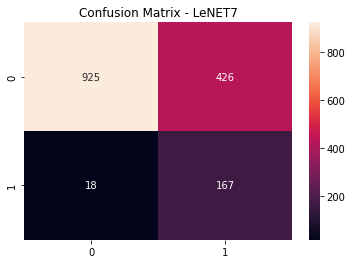

OA: 0.7109375
F1 score: 0.429305912596401


In [33]:
# LeNET7
conf_matrix(y_true_le.cpu(),y_pred_le.cpu(),'LeNET7')
print('OA:', accuracy_score(y_true_le.cpu(), y_pred_le.cpu()))
print('F1 score:', f1_score(y_true_le.cpu(),y_pred_le.cpu()))

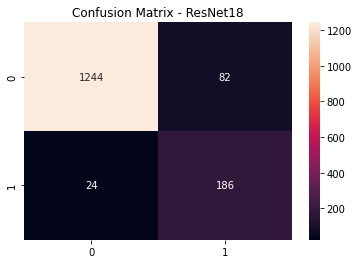

OA: 0.9309895833333334
F1 score: 0.7782426778242679


In [34]:
# Resnet18
conf_matrix(y_true_res.cpu(),y_pred_res.cpu(),'ResNet18')
print('OA:', accuracy_score(y_true_res.cpu(),y_pred_res.cpu()))
print('F1 score:', f1_score(y_true_res.cpu(),y_pred_res.cpu()))